In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
from example_graphs import make_tree
from utils import nice_tree_plot, without_diag
from compute_pam import compute_combo_tensor_pam, IndividualNodeAlphaCalc
from tree_extraction.Aho import get_ratio_matrix

In [3]:
def get_min_diff_from_ratio_matrix(ratio_matrix, return_dict = False):
    dropped_diagonal = []
    for i in range(ratio_matrix.shape[0]):
        sortedRow = sorted(list(ratio_matrix[i, :i]) + list(ratio_matrix[i, i+1:]))
        dropped_diagonal.append(sortedRow)
    dropped_diagonal = np.array(dropped_diagonal).round(decimals = 10)
    diffs = np.diff(dropped_diagonal, axis=1)
    unique_values = np.unique(dropped_diagonal)
    min_diff = np.min(np.diff(unique_values))
    
    if return_dict:
        return dict(
            dropped_diagonal = dropped_diagonal,
            diffs = diffs,
            unique_values = unique_values,
            min_diff = min_diff,
        )
    else:
        return min_diff

def get_min_diff_from_graph(g, alphas, return_dict = False):
    R, lp = compute_combo_tensor_pam(
        g,
        alpha=IndividualNodeAlphaCalc(g, alphas),
        return_leaf_paths=True)
    C = get_ratio_matrix(R)

    result = get_min_diff_from_ratio_matrix(C, return_dict = return_dict)

    if return_dict:
        result["R"] = R
        result["C"] = C
    return result

In [4]:
class SharedCalc(object):
    def _init_all(self):
        if not hasattr(self, "verbose"):
            self.verbose = False
        self._init_graph()
        self._init_sum_alphas()
        self._init_matrices()
        self._init_diffs()
    
    @classmethod
    def get_offset(cls, b, factor = 10):
        offset = factor
        while np.max(b) + 1 >= offset:
            offset *= factor
        return offset

    def _init_graph(self):
        s2 = self.s2
        b = self.b
        alphas_by_depth = self.alphas_by_depth
        offset = self.offset

        triplet = [0, 0, 0]

        alphas = dict()
        g = nx.DiGraph()
        g.graph["root"] = 0
        for i in range(len(b)):
            for j in range(b[i]):
                srcIndex = i * offset
                dstIndex = j + (i + 1) * offset
                g.add_edge(srcIndex, dstIndex)
                alphas[dstIndex] = alphas_by_depth[i]
                if i == 0 and j == b[i] - 1:
                    triplet[2] = dstIndex
                if i == s2 and j == 1:
                    triplet[0] = dstIndex
                if i == s2 and j == 2:
                    triplet[1] = dstIndex
                if i == s2 and s2 == len(b) - 1 and j == 0:
                    triplet[1] = dstIndex
                    
        self.g = g
        self.triplet = triplet
        self.alphas = alphas
        
    def _init_matrices(self):
        self.R, lp = compute_combo_tensor_pam(self.g,
            alpha = IndividualNodeAlphaCalc(self.g, self.alphas),
            return_leaf_paths = True)
        self.C = get_ratio_matrix(self.R)
        
        self.leaves = [p[-1] for p in lp]
        self.leaf_to_index = {k: i for i, k in enumerate(self.leaves)}
        
    def _init_diffs(self):
        C = self.C

        result = get_min_diff_from_ratio_matrix(C, return_dict = True)

        self.dropped_diagonal = result["dropped_diagonal"]
        self.diffs = result["diffs"]
        self.unique_values = result["unique_values"]
        self.min_diff = result["min_diff"]
        
        i, j, k = [self.leaf_to_index[x] for x in self.triplet]
        self.triplet_diff = self.C[i, j] - self.C[i, k]
        
    def _init_sum_alphas(self):
        result = dict()
        for n in self.g.nodes():
            nbrs = list(self.g.neighbors(n))
            if len(nbrs) == 0:
                continue
            result[n] = np.sum([self.alphas[x] for x in nbrs])
        self.sum_alphas = result
        
        delta_dict = dict()
        for n in self.g.nodes():
            if n in self.alphas and n in self.sum_alphas:
                # Note: `alphas` corresponds to parent->n, whereas `sum_alphas` corresponds to n->children
                delta_dict[n] = self.sum_alphas[n] - self.alphas[n]
        self.observed_dmin = np.min(list(delta_dict.values()))
        self.delta_dict = delta_dict

In [5]:
class Analysis1(SharedCalc):
    def __init__(self, s1, s2, b, dmin, alpha0):
        self.s1 = s1
        self.s2 = s2
        self.b = b
        self.dmin = dmin
        self.alpha0 = alpha0
        self.alphas_by_depth = self.get_alphas_by_depth()
        self.offset = self.get_offset(b)
        self._init_all()

    def get_alphas_by_depth(self):
        alphas_by_depth = [self.alpha0]
        for i in range(len(self.b) - 1):
            a = (self.dmin + alphas_by_depth[-1]) / self.b[i+1]
            alphas_by_depth.append(a)
        alphas_by_depth = np.array(alphas_by_depth, dtype='float')
        return alphas_by_depth

In [6]:
analysis_specs = [
    dict(s1 = 0, s2 = 1, b = np.array([3,4,5,6]), dmin = 0.1, alpha0 = 1.0),
    #dict(s1 = 0, s2 = 2, b = np.array([3,4,5,6]), dmin = 0.1, alpha0 = 1.0),
    #dict(s1 = 0, s2 = 3, b = np.array([3,4,5,6]), dmin = 0.1, alpha0 = 1.0),
    dict(s1 = 0, s2 = 1, b = np.array([2,2]), dmin = 0.1, alpha0 = 1.0),
    dict(s1 = 0, s2 = 1, b = np.array([2,100]), dmin = 0.1, alpha0 = 1.0),
    dict(s1 = 0, s2 = 1, b = np.array([100,2]), dmin = 0.1, alpha0 = 1.0),
]
for spec in analysis_specs:
    print("#" * 20)
    print(spec)
    a = Analysis1(**spec)
    #nice_tree_plot(a.g)
    #plt.show()
    print("triplet:", a.triplet)
    print("sum_alphas:", a.sum_alphas)
    #print("alphas:", a.alphas)
    print("observed dmin:", a.observed_dmin)
    print("min diff:    ", a.min_diff)
    print("example diff:", a.triplet_diff)

####################
{'s1': 0, 's2': 1, 'b': array([3, 4, 5, 6]), 'dmin': 0.1, 'alpha0': 1.0}
triplet: [21, 22, 12]
sum_alphas: {0: 3.0, 10: 1.1, 20: 0.375, 30: 0.175}
observed dmin: 0.09999999999999998
min diff:     0.035714285700000015
example diff: 0.035714285714285254
####################
{'s1': 0, 's2': 1, 'b': array([2, 2]), 'dmin': 0.1, 'alpha0': 1.0}
triplet: [21, 20, 11]
sum_alphas: {0: 2.0, 10: 1.1}
observed dmin: 0.10000000000000009
min diff:     0.03174603170000001
example diff: 0.03174603174603163
####################
{'s1': 0, 's2': 1, 'b': array([  2, 100]), 'dmin': 0.1, 'alpha0': 1.0}
triplet: [2001, 2002, 1001]
sum_alphas: {0: 2.0, 1000: 1.0999999999999994}
observed dmin: 0.09999999999999942
min diff:     0.03174603170000001
example diff: 0.03174603174603219
####################
{'s1': 0, 's2': 1, 'b': array([100,   2]), 'dmin': 0.1, 'alpha0': 1.0}
triplet: [2001, 2000, 1099]
sum_alphas: {0: 100.0, 1000: 1.1}
observed dmin: 0.10000000000000009
min diff:     0.047147571

## Alternate analysis

In [7]:
class Analysis2(SharedCalc):
    def __init__(self, s1, s2, b, alpha):
        self.s1 = s1
        self.s2 = s2
        self.b = b
        self.alphas_by_depth = alpha
        self.offset = self.get_offset(b)
        self._init_all()

####################
{'s1': 0, 's2': 1, 'b': array([2, 2]), 'alpha': array([0.01, 1.  ])}


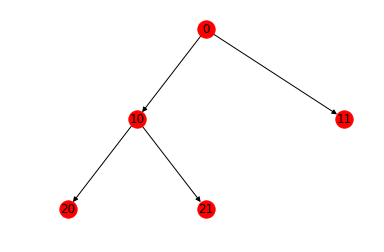

triplet: [21, 20, 11]
sum_alphas: {0: 0.02, 10: 2.0}
alphas: {10: 0.01, 11: 0.01, 20: 1.0, 21: 1.0}
observed dmin: 1.99
observed deltas: {10: 1.99}
min diff:     1.3006535948
example diff: 1.3006535947712423


In [8]:
analysis_specs = [
    #dict(s1 = 0, s2 = 1, b = np.array([3,4,5,6]), alpha = np.array([1, 1, 1, 1], dtype='float')),
    #dict(s1 = 0, s2 = 2, b = np.array([2,2,2]), alpha = np.array([3, 3.5, 1])),
    dict(s1 = 0, s2 = 1, b = np.array([2,2]), alpha = np.array([1/100,1])),
    #dict(s1 = 0, s2 = 1, b = np.array([3,4]), alpha = np.array([1, 1], dtype='float')),
    #dict(s1 = 0, s2 = 1, b = np.array([2,2]), alpha = np.array([1, 1], dtype='float')),
    #dict(s1 = 0, s2 = 1, b = np.array([2,2]), alpha = np.array([10, 10], dtype='float')),
    #dict(s1 = 0, s2 = 1, b = np.array([2,100]), alpha = np.array([10, .00001], dtype='float')),
    #dict(s1 = 0, s2 = 1, b = np.array([2,100]), alpha = np.array([1, 1], dtype='float')),
    #dict(s1 = 0, s2 = 1, b = np.array([100,2]), alpha = np.array([1, 1], dtype='float')),
    #dict(s1 = 0, s2 = 1, b = np.array([100,100]), alpha = np.array([1, 1], dtype='float')),
]
for spec in analysis_specs:
    print("#" * 20)
    print(spec)
    a = Analysis2(**spec)
    nice_tree_plot(a.g)
    plt.show()
    print("triplet:", a.triplet)
    print("sum_alphas:", a.sum_alphas)
    print("alphas:", a.alphas)
    print("observed dmin:", a.observed_dmin)
    print("observed deltas:", a.delta_dict)
    print("min diff:    ", a.min_diff)
    print("example diff:", a.triplet_diff)

In [9]:
a.C

array([[1.98039216, 0.01960784, 0.01960784],
       [0.01960784, 2.64052288, 1.32026144],
       [0.01960784, 1.32026144, 2.64052288]])

In [10]:
def fz(b0, b1, a0, a1):
    return b0 / (1 + b0*a0) * ((b1*a1 - a0) / (1 + b1*a1))

In [11]:
fz(2,2,1,1)

0.2222222222222222

In [12]:
fz(2,7,1,1/7)

0.0

In [13]:
fz(2,200,1/100,1)

1.9509316164276658

In [14]:
fz(2,2,1/100,1)

1.3006535947712419

In [15]:
from scipy.optimize import minimize

In [16]:
dmin = 1.0
alpha_max = 1.0

def f(x):
    a1, a2, a3, a4 = x
    return (a1 + a2) / (1 + a1 + a2) * ((a3 + a4) * (1 + a1) / ((1 + a3 + a4) * (a1)) - 1)

def c1(x, dmin):
    a1, a2, a3, a4 = np.atleast_2d(x).transpose()
    r = a3 + a4
    r = r - a1
    r = r - dmin
    return r

def c2(x, i, alpha_max):
    return alpha_max - np.asarray(x)[..., i]

constrs = [
    dict(fun=c1, type='ineq', args=(dmin,))
]

def mk_constr(index):
    return lambda x: np.asarray(x)[..., index]

for i in range(4):
    zz = mk_constr(i)
    constrs.append(dict(fun=zz, type='ineq'))
    constrs.append(dict(fun=c2, type='ineq', args=(i, alpha_max)))

for i, c in enumerate(constrs):
    print(c)
    print('   ', c['fun']([10,20,30,40], *c.get('args', ())))

{'fun': <function c1 at 0x115f1df28>, 'type': 'ineq', 'args': (1.0,)}
    [59.]
{'fun': <function mk_constr.<locals>.<lambda> at 0x11611f9d8>, 'type': 'ineq'}
    10
{'fun': <function c2 at 0x10fb99f28>, 'type': 'ineq', 'args': (0, 1.0)}
    -9.0
{'fun': <function mk_constr.<locals>.<lambda> at 0x11611f950>, 'type': 'ineq'}
    20
{'fun': <function c2 at 0x10fb99f28>, 'type': 'ineq', 'args': (1, 1.0)}
    -19.0
{'fun': <function mk_constr.<locals>.<lambda> at 0x11611fb70>, 'type': 'ineq'}
    30
{'fun': <function c2 at 0x10fb99f28>, 'type': 'ineq', 'args': (2, 1.0)}
    -29.0
{'fun': <function mk_constr.<locals>.<lambda> at 0x11611f158>, 'type': 'ineq'}
    40
{'fun': <function c2 at 0x10fb99f28>, 'type': 'ineq', 'args': (3, 1.0)}
    -39.0


In [17]:
sol = minimize(f, x0 = [1,1,1,1], constraints=constrs, method='SLSQP')

In [18]:
print(sol.message)
print(sol.fun)
sol.x

Optimization terminated successfully.
0.16666666666666655


array([1., 0., 1., 1.])

In [19]:
f(sol.x)

0.16666666666666655

In [20]:
f([1,1e-5,1,1])

0.16666749999583333

## Yet another alternate analysis

In [21]:
def min_diff(alpha_a_vec, alpha_other_vec, alpha_b, alpha_c, s1, s2, verbose = False):
    assert s1 != s2
    def f(k):
        s = alpha_a_vec[..., k] + alpha_other_vec[..., k]
        if k == s1:
            s += alpha_c
        elif k == s2:
            s += alpha_b
        return s / (1 + s)
    def g(k):
        return alpha_a_vec[..., k] / (1 + alpha_a_vec[..., k])
    result = f(0)
    if verbose: print("DEBUG: f(0) = {}".format(f(0)))
    for k in range(1, s1+1):
        if verbose: print("DEBUG: k = {0}, f(k) / g(k-1) = f({0}) / g({1}) = {2} / {3} = {4}".format(k, k - 1, f(k), g(k-1), f(k) / g(k-1)))
        result *= f(k) / g(k-1)
    factor = 1
    for k in range(s1+1, s2+1):
        if verbose: print("DEBUG: k = {0}, f(k) / g(k-1) = f({0}) / g({1}) = {2} / {3} = {4}".format(k, k - 1, f(k), g(k-1), f(k) / g(k-1)))
        factor *= f(k) / g(k-1)
    if verbose: print("DEBUG: factor = {}, factor - 1 = {}".format(factor, factor - 1))
    result *= factor - 1
    if verbose: print("DEBUG: result = {}".format(result))
    return result

In [22]:
def make_objective(s1, s2, verbose = False):
    def objective(x):
        alpha_a_vec = x[..., :s2+1]
        alpha_other_vec = x[..., s2+1:s2*2+2]
        alpha_b = x[..., s2*2+2]
        alpha_c = x[..., s2*2+3]
        if verbose:
            print(alpha_a_vec)
            print(alpha_other_vec)
            print(alpha_b)
            print(alpha_c)
        return min_diff(alpha_a_vec, alpha_other_vec, alpha_b, alpha_c, s1, s2, verbose = verbose)
    return objective

In [23]:
s1 = 0
s2 = 1

In [24]:
make_objective(s1, s2, verbose=True)(np.array([10, 20, 30, 40, 50, 60]))

[10 20]
[30 40]
50
60
DEBUG: f(0) = 0.9900990099009901
DEBUG: k = 1, f(k) / g(k-1) = f(1) / g(0) = 0.990990990990991 / 0.9090909090909091 = 1.09009009009009
DEBUG: factor = 1.09009009009009, factor - 1 = 0.09009009009009006
DEBUG: result = 0.08919810900008916


0.08919810900008916

In [25]:
aav_0 = np.array([1,1])
aov_0 = np.array([1,1])
ab_0 = 1
ac_0 = 1

max_alpha = 1
min_delta = 0.1

size_o = np.array([1, 1])

def mk_c(i):
    return lambda x: x[..., i]
def mk_c2(i):
    if i < s2 + 1 or i >= s2*2 + 2:
        ceiling = max_alpha
    else:
        ceiling = max_alpha * size_o[i - (s2 + 1)]
    return lambda x: ceiling - x[..., i]
def mk_c3(i):
    def c(x):
        alpha_a_vec = x[..., :s2+1]
        alpha_other_vec = x[..., s2+1:s2*2+2]
        alpha_b = x[..., s2*2+2]
        alpha_c = x[..., s2*2+3]
        if i == s1:
            return alpha_a_vec[i] + alpha_other_vec[i] + alpha_c - alpha_a_vec[i-1] - min_delta
        elif i == s2:
            return alpha_a_vec[i] + alpha_other_vec[i] + alpha_b - alpha_a_vec[i-1] - min_delta
        else:
            return alpha_a_vec[i] + alpha_other_vec[i] - alpha_a_vec[i-1] - min_delta
    return c
constrs = []
for i in range(2 * (s2+1) + 2):
    constrs.append(dict(fun = mk_c(i), type='ineq'))
    constrs.append(dict(fun = mk_c2(i), type='ineq'))
for i in range(1, s2 + 1):
    constrs.append(dict(fun = mk_c3(i), type='ineq'))
    
x0 = np.array(list(aav_0) + list(aov_0) + [ab_0, ac_0])
sol = minimize(make_objective(s1, s2), x0 = x0, constraints = constrs)
sol

     fun: 0.0238095238095204
     jac: array([-0.25000001,  0.22675737,  0.01190476,  0.22675737,  0.22675737,
        0.01190476])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 1.00000000e+00,  3.66666667e-01, -2.18353113e-13,  3.66666667e-01,
        3.66666667e-01, -1.81993309e-13])

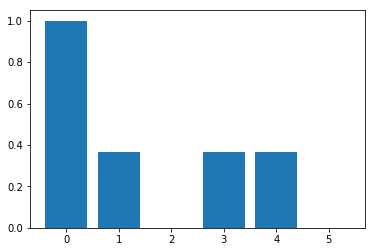

In [26]:
plt.bar(np.arange(len(sol.x)), sol.x);

In [27]:
make_objective(s1, s2, verbose=True)(sol.x)

[1.         0.36666667]
[-2.18353113e-13  3.66666667e-01]
0.36666666666666703
-1.8199330931167879e-13
DEBUG: f(0) = 0.4999999999998999
DEBUG: k = 1, f(k) / g(k-1) = f(1) / g(0) = 0.5238095238095251 / 0.49999999999999994 = 1.0476190476190503
DEBUG: factor = 1.0476190476190503, factor - 1 = 0.047619047619050336
DEBUG: result = 0.0238095238095204


0.0238095238095204

0-mk_c	0.9999999999999999
1-mk_c2	1.1102230246251565e-16
2-mk_c	0.36666666666668285
3-mk_c2	0.6333333333333171
4-mk_c	-2.1835311336815266e-13
5-mk_c2	1.0000000000002183
6-mk_c	0.3666666666666556
7-mk_c2	0.6333333333333444
8-mk_c	0.36666666666666703
9-mk_c2	0.633333333333333
10-mk_c	-1.8199330931167879e-13
11-mk_c2	1.000000000000182
12-mk_c3	5.523359547510154e-15


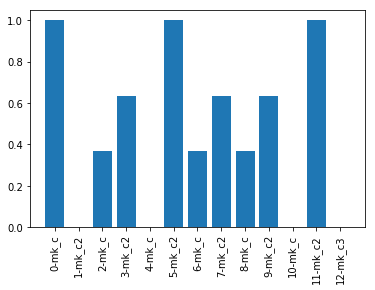

In [46]:
xvals = []
vals = []
for i, c in enumerate(constrs):
    name = c["fun"].__qualname__.split('.')[0]
    name = str(i) + '-' + name
    v = c["fun"](sol.x)
    print(name, v, sep='\t')
    xvals.append(name)
    vals.append(v)

fig, ax = plt.subplots()    
ax.bar(xvals, vals);
ax.tick_params(axis='x',rotation=90)

## Trying again...

Minimize
$$\frac{\alpha_{0} + \alpha_{02} + b_0\alpha_{0x}}{1 + \alpha_{0} + \alpha_{02} + b_0\alpha_{0x}}
    \left[ \frac{\alpha_{1} + \alpha_{12} + b_1\alpha_{1x}}{1 + \alpha_{1} + \alpha_{12} + b_1\alpha_{1x}} \cdot
    \frac{1 + \alpha_{0}}{\alpha_{0}} - 1 \right]
    =
    \frac{\alpha_{0} + \alpha_{02} + b_0\alpha_{0x}}{1 + \alpha_{0} + \alpha_{02} + b_0\alpha_{0x}}
    \cdot
    \frac{\alpha_{1} + \alpha_{12} + b_1\alpha_{1x} - \alpha_{0}}
         {\left( 1 + \alpha_{1} + \alpha_{12} + b_1\alpha_{1x} \right) \alpha_{0}}
    $$
(with $b_0$, $b_1$ being fixed non-negative integers)
subject to each $\alpha$ variable being between $0$ and $\alpha_\text{max}$, and also
$$
\alpha_{1} + \alpha_{12} + b_1\alpha_{1x} - \alpha_{0} \geq \delta_\text{min}
$$

In [109]:
min_delta = 1.0
max_alpha = 1.0
size_o = np.array([1, 1])  # number of "other" elements bundled into to alpha_{kx} at each depth

def f(a):
    sum0 = (a[0] + a[2] + a[4])
    sum1 = (a[1] + a[3] + a[5])
    return (sum0 * (sum1 - a[0])) / ((1 + sum0) * (1 + sum1) * a[0])

def c(a):
    sum1 = (a[1] + a[3] + a[5])
    return sum1 - a[0] - min_delta

constrs = [
    dict(fun = c, type = 'ineq'),
]
def bounds(i):
    if i == 4:
        factor = size_o[0]
    elif i == 5:
        factor = size_o[1]
    else:
        factor = 1
    return [
        dict(fun = lambda a: a[i], type = 'ineq'),
        dict(fun = lambda a: max_alpha * factor - a[i], type = 'ineq'),
    ]

for i in range(6):
    constrs.extend(bounds(i))

In [110]:
sol = minimize(f, x0 = np.ones(6), constraints=constrs)
print(sol.message)
print(sol.x)
print(sol.fun)

Optimization terminated successfully.
[ 1.00000000e+00  6.66666667e-01 -4.97241137e-14  6.66666667e-01
 -5.98687766e-14  6.66666667e-01]
0.1666666666666597
